# DATA PREP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path

In [2]:
DATA_PATH = Path("datasets/CMaps/")
images_dir = "images"

In [3]:
indexes = ['unit_number', 'time_cycles']
settings = ['setting_1', 'setting_2', 'setting_3']
sensors = ['s_{}'.format(i+1) for i in range(0,21)]
COLS = indexes + settings + sensors

In [4]:
def load_fd_dataset(dataset_id):
    """
    Load train/test/RUL files for a single FD dataset (e.g., FD001, FD002, etc.)
    
    :param dataset_id: integer 1..4, e.g. for FD001 use dataset_id=1
    :return: df_train, df_test, df_rul (pandas DataFrames)
    """

    train_file = DATA_PATH / f"train_FD00{dataset_id}.txt"
    test_file  = DATA_PATH / f"test_FD00{dataset_id}.txt"
    rul_file   = DATA_PATH / f"RUL_FD00{dataset_id}.txt"

    df_train = pd.read_csv(
        train_file,
        sep=r"\s+",        
        header=None,
        names=COLS,
        index_col=False
    )

    df_test = pd.read_csv(
        test_file,
        sep=r"\s+",
        header=None,
        names=COLS,
        index_col=False
    )

    df_rul = pd.read_csv(
        rul_file,
        sep=r"\s+",
        header=None,
        names=["RUL"],
        index_col=False
    )
    
    return df_train, df_test, df_rul

def add_train_rul(df_train):
    """
    For the training set, calculate RUL for every row.
    NASA’s train data runs each engine to failure, so:
      RUL = (last cycle for that engine) - (current cycle).
    """
    # Group by unit and get the max cycle of each engine
    max_cycle = df_train.groupby("unit_number")["time_cycles"].transform("max")
    # RUL = distance to max cycle
    df_train["RUL"] = max_cycle - df_train["time_cycles"]
    return df_train

def add_test_rul(df_test, df_rul):
    """
    For the test set, each engine is truncated before failure. 
    NASA gives a single RUL for the *last* row of each engine in df_rul.
    
    Typically, we only need that final row to evaluate or predict RUL. 
    So we can 'merge' that RUL onto the final snapshot of each engine.
    
    If you want row-level RUL for the entire partial test run (less common),
    you need a different approach. Usually, we label only the last row.
    """
    # Identify the final row for each engine in the test set
    # i.e., the row with the maximum 'time_cycles' for that unit_number
    idx = df_test.groupby("unit_number")["time_cycles"].transform("max") == df_test["time_cycles"]
    final_test_rows = df_test[idx].copy().reset_index(drop=True)
    
    # Attach RUL from df_rul, which is one row per engine
    # RUL rows match by index => engine 1 => df_rul.loc[0], engine 2 => df_rul.loc[1], etc.
    # final_test_rows are also in ascending engine order, so we can do direct assignment
    final_test_rows["RUL"] = df_rul["RUL"]
    
    return final_test_rows


In [5]:
datasets = {}  

for i in range(1, 5):
    
    df_train_raw, df_test_raw, df_rul = load_fd_dataset(i)
    df_train = add_train_rul(df_train_raw)
    df_test_final = add_test_rul(df_test_raw, df_rul)
    key = f"FD00{i}"
    datasets[key] = {
        "train":       df_train,   
        "test":        df_test_raw,
        "rul":         df_rul,
        "test_final":  df_test_final,
    }

# RANDOM FOREST PIPELINE FOR FD001 and FD003


 Running Random Forest on FD001
   Results for FD001:
  🔸 RMSE: 34.13
  🔸 MAE:  24.75
  🔸 R²:   0.33


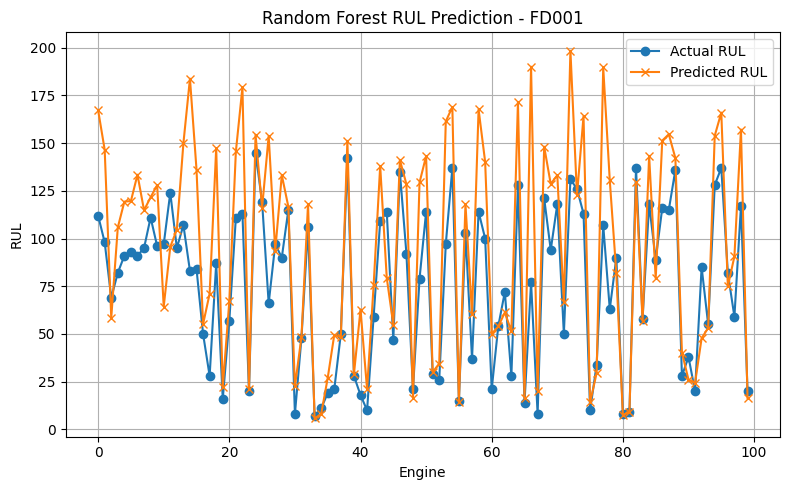


 Running Random Forest on FD003
   Results for FD003:
  🔸 RMSE: 44.99
  🔸 MAE:  32.80
  🔸 R²:   -0.18


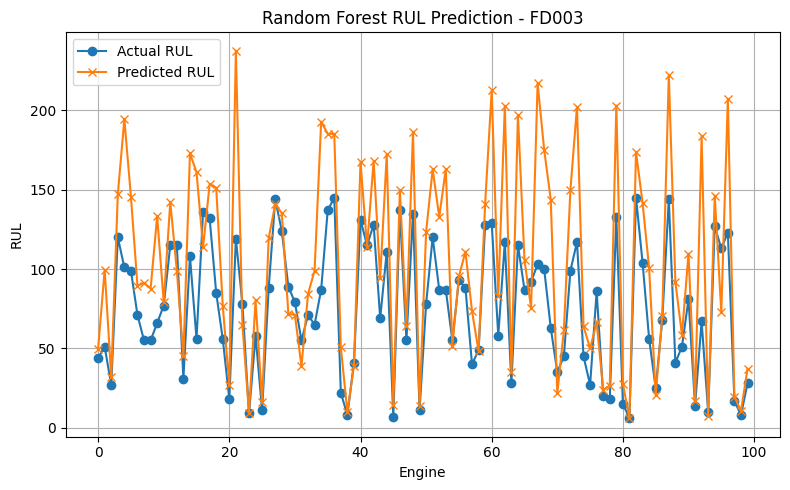

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


for dataset_id in ["FD001", "FD003"]:
    print(f"\n Running Random Forest on {dataset_id}")

    
    df_train = datasets[dataset_id]["train"]
    df_test_final = datasets[dataset_id]["test_final"]

    
    X_train = df_train.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_train = df_train["RUL"]

    X_test = df_test_final.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_test = df_test_final["RUL"]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    
    y_pred = rf.predict(X_test_scaled)

    
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"   Results for {dataset_id}:")
    print(f"  🔸 RMSE: {rmse:.2f}")
    print(f"  🔸 MAE:  {mae:.2f}")
    print(f"  🔸 R²:   {r2:.2f}")

    
    plt.figure(figsize=(8, 5))
    plt.plot(y_test.values, label='Actual RUL', marker='o')
    plt.plot(y_pred, label='Predicted RUL', marker='x')
    plt.title(f"Random Forest RUL Prediction - {dataset_id}")
    plt.xlabel("Engine")
    plt.ylabel("RUL")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# USING HELPER FUNCTIONS TO CALCULATE RUL

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


column_names = ['unit_number', 'time_cycles'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

# FD001
train_fd001 = pd.read_csv(r"datasets/Cmaps/train_FD001.txt", sep=r"\s+", header=None, names=column_names)
test_fd001 = pd.read_csv(r"datasets/Cmaps/test_FD001.txt", sep=r"\s+", header=None, names=column_names)
rul_fd001 = pd.read_csv(r"datasets/Cmaps/RUL_FD001.txt", sep=r"\s+", header=None)

# FD003
train_fd003 = pd.read_csv(r"datasets/Cmaps/train_FD003.txt", sep=r"\s+", header=None, names=column_names)
test_fd003 = pd.read_csv(r"datasets/Cmaps/test_FD003.txt", sep=r"\s+", header=None, names=column_names)
rul_fd003 = pd.read_csv(r"datasets/Cmaps/RUL_FD003.txt", sep=r"\s+", header=None)

# Helper functions to calculate RUL for train and test datasets
def calculate_rul_train(df):
    max_cycles = df.groupby("unit_number")["time_cycles"].transform("max")
    df["RUL"] = max_cycles - df["time_cycles"]
    return df

def calculate_rul_test(df, rul_data):
    # Get the max cycle for each unit in test set
    max_cycles = df.groupby("unit_number")["time_cycles"].max().reset_index()
    max_cycles["RUL"] = rul_data[0]
    df = df.merge(max_cycles, on="unit_number", how="left", suffixes=("", "_max"))
    df["RUL"] = df["RUL"] + (df["time_cycles_max"] - df["time_cycles"])
    df.drop(columns=["time_cycles_max"], inplace=True)
    return df

# Compute RUL columns
train_fd001 = calculate_rul_train(train_fd001)
test_fd001 = calculate_rul_test(test_fd001, rul_fd001)

train_fd003 = calculate_rul_train(train_fd003)
test_fd003 = calculate_rul_test(test_fd003, rul_fd003)


datasets = {
    "FD001": {
        "train": train_fd001,
        "test_final": test_fd001,
    },
    "FD003": {
        "train": train_fd003,
        "test_final": test_fd003,
    }
}


results = {}

for dataset_id in ["FD001", "FD003"]:
    print(f"\nRunning Random Forest on {dataset_id}")

    # Load train and test_final
    df_train = datasets[dataset_id]["train"]
    df_test_final = datasets[dataset_id]["test_final"]

   
    X_train = df_train.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_train = df_train["RUL"]

    X_test = df_test_final.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_test = df_test_final["RUL"]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

   
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

 
    y_pred = rf.predict(X_test_scaled)


    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    
    importances = rf.feature_importances_
    feature_names = X_train.columns

    results[dataset_id] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "y_test": y_test,
        "y_pred": y_pred,
        "features": feature_names,
        "importances": importances
    }


for dataset_id, result in results.items():
    print(f"\nResults for {dataset_id}:")
    print(f"RMSE: {result['RMSE']}")
    print(f"MAE: {result['MAE']}")
    print(f"R²: {result['R2']}")

    
    print("\nFeature Importances:")
    for feature, importance in zip(result['features'], result['importances']):
        print(f"{feature}: {importance}")



Running Random Forest on FD001

Running Random Forest on FD003

Results for FD001:
RMSE: 46.32193753980901
MAE: 35.00478390348198
R²: 0.38312754194894827

Feature Importances:
operational_setting_1: 0.02258287365588958
operational_setting_2: 0.013650682073657059
operational_setting_3: 0.0
sensor_measurement_1: 0.0
sensor_measurement_2: 0.02729910923385049
sensor_measurement_3: 0.028470924931284475
sensor_measurement_4: 0.09207109636132683
sensor_measurement_5: 0.0
sensor_measurement_6: 0.0007229881677350484
sensor_measurement_7: 0.037332762909780215
sensor_measurement_8: 0.020050202405600976
sensor_measurement_9: 0.12402856384761124
sensor_measurement_10: 0.0
sensor_measurement_11: 0.434919656624683
sensor_measurement_12: 0.04387764047036615
sensor_measurement_13: 0.02082895621769523
sensor_measurement_14: 0.037010839689600394
sensor_measurement_15: 0.03303423314935211
sensor_measurement_16: 0.0
sensor_measurement_17: 0.009141334238492786
sensor_measurement_18: 0.0
sensor_measurement_

Down below is different from doing calculating every measurements and settings of feature improtances and showing results with average working model and best working model diffrences 


Running Random Forest on FD001
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Running Random Forest on FD003
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Results for FD001:
RMSE: 46.32193753980901
MAE: 35.00478390348198
R²: 0.38312754194894827
RMSE (Best Model): 45.85149475759226
MAE (Best Model): 34.42520566212287
R² (Best Model): 0.39559375419160725

Feature Importances:
operational_setting_1: 0.02258287365588958
operational_setting_2: 0.013650682073657059
operational_setting_3: 0.0
sensor_measurement_1: 0.0
sensor_measurement_2: 0.02729910923385049
sensor_measurement_3: 0.028470924931284475
sensor_measurement_4: 0.09207109636132683
sensor_measurement_5: 0.0
sensor_measurement_6: 0.0007229881677350484
sensor_measurement_7: 0.037332762909780215
sensor_measurement_8: 0.020050202405600976
sensor_measurement_9: 0.12402856384761124
sensor_measurement_10: 0.0
sensor_measurement_11: 0.434919656624683
sensor_measurement_12: 0.04387764047036615
sensor_measur

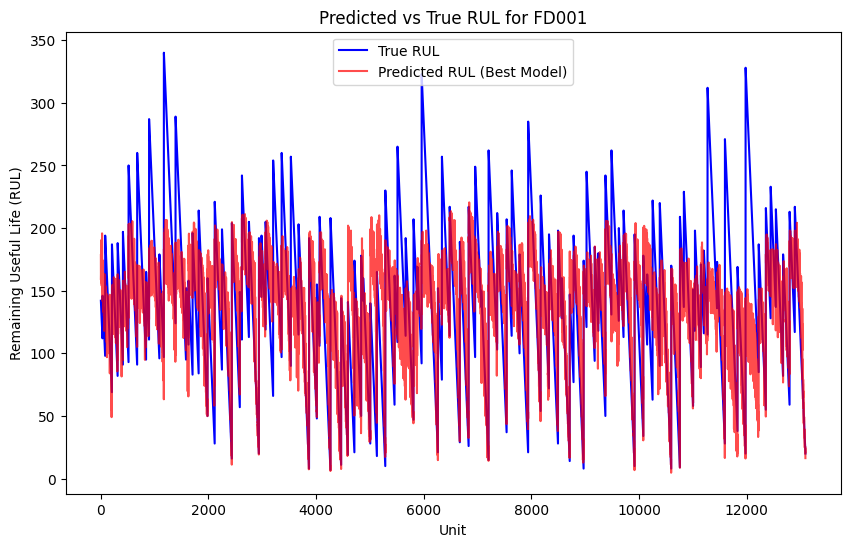


Results for FD003:
RMSE: 69.16371980611406
MAE: 50.53614846951073
R²: 0.32565793630564877
RMSE (Best Model): 68.6227131882669
MAE (Best Model): 50.05863722537967
R² (Best Model): 0.3361662396266243

Feature Importances:
operational_setting_1: 0.019259163395599233
operational_setting_2: 0.012168293346683052
operational_setting_3: 0.0
sensor_measurement_1: 0.0
sensor_measurement_2: 0.022575648569726263
sensor_measurement_3: 0.024850941336271314
sensor_measurement_4: 0.033315417264758056
sensor_measurement_5: 0.0
sensor_measurement_6: 0.034663961960969734
sensor_measurement_7: 0.034828453387587985
sensor_measurement_8: 0.019895799691952848
sensor_measurement_9: 0.08341523750220152
sensor_measurement_10: 9.233081714114227e-05
sensor_measurement_11: 0.4486743724938372
sensor_measurement_12: 0.1299183013594289
sensor_measurement_13: 0.024295614792917208
sensor_measurement_14: 0.034746734649543067
sensor_measurement_15: 0.02565570583285795
sensor_measurement_16: 0.0
sensor_measurement_17: 0.

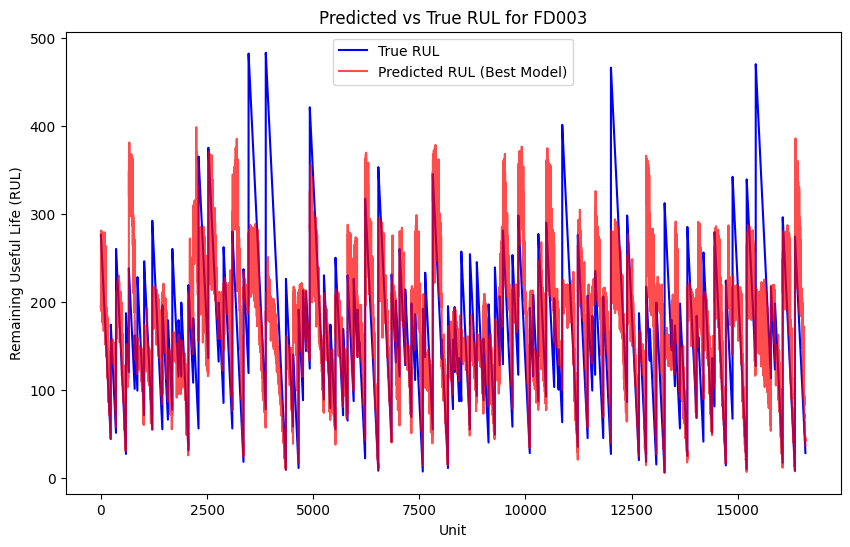

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


column_names = ['unit_number', 'time_cycles'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

# FD001
train_fd001 = pd.read_csv(r"datasets/Cmaps/train_FD001.txt", sep=r"\s+", header=None, names=column_names)
test_fd001 = pd.read_csv(r"datasets/Cmaps/test_FD001.txt", sep=r"\s+", header=None, names=column_names)
rul_fd001 = pd.read_csv(r"datasets/Cmaps/RUL_FD001.txt", sep=r"\s+", header=None)

# FD003
train_fd003 = pd.read_csv(r"datasets/Cmaps/train_FD003.txt", sep=r"\s+", header=None, names=column_names)
test_fd003 = pd.read_csv(r"datasets/Cmaps/test_FD003.txt", sep=r"\s+", header=None, names=column_names)
rul_fd003 = pd.read_csv(r"datasets/Cmaps/RUL_FD003.txt", sep=r"\s+", header=None)


def calculate_rul_train(df):
    max_cycles = df.groupby("unit_number")["time_cycles"].transform("max")
    df["RUL"] = max_cycles - df["time_cycles"]
    return df

def calculate_rul_test(df, rul_data):
    max_cycles = df.groupby("unit_number")["time_cycles"].max().reset_index()
    max_cycles["RUL"] = rul_data[0]
    df = df.merge(max_cycles, on="unit_number", how="left", suffixes=("", "_max"))
    df["RUL"] = df["RUL"] + (df["time_cycles_max"] - df["time_cycles"])
    df.drop(columns=["time_cycles_max"], inplace=True)
    return df

train_fd001 = calculate_rul_train(train_fd001)
test_fd001 = calculate_rul_test(test_fd001, rul_fd001)

train_fd003 = calculate_rul_train(train_fd003)
test_fd003 = calculate_rul_test(test_fd003, rul_fd003)

datasets = {
    "FD001": {
        "train": train_fd001,
        "test_final": test_fd001,
    },
    "FD003": {
        "train": train_fd003,
        "test_final": test_fd003,
    }
}

results = {}

for dataset_id in ["FD001", "FD003"]:
    print(f"\nRunning Random Forest on {dataset_id}")


    df_train = datasets[dataset_id]["train"]
    df_test_final = datasets[dataset_id]["test_final"]


    X_train = df_train.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_train = df_train["RUL"]

    X_test = df_test_final.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_test = df_test_final["RUL"]


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model with default paramete
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)


    y_pred = rf.predict(X_test_scaled)


    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    importances = rf.feature_importances_
    feature_names = X_train.columns

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    # Best hyperparameters
    best_rf = grid_search.best_estimator_

    # Predict with the best model
    y_pred_best = best_rf.predict(X_test_scaled)

    # Evaluate the best model
    rmse_best = mean_squared_error(y_test, y_pred_best) ** 0.5
    mae_best = mean_absolute_error(y_test, y_pred_best)
    r2_best = r2_score(y_test, y_pred_best)

    # Save feature importances from the best model
    importances_best = best_rf.feature_importances_

    results[dataset_id] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "RMSE_best": rmse_best,
        "MAE_best": mae_best,
        "R2_best": r2_best,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_pred_best": y_pred_best,
        "features": feature_names,
        "importances": importances,
        "importances_best": importances_best
    }


for dataset_id, result in results.items():
    print(f"\nResults for {dataset_id}:")
    print(f"RMSE: {result['RMSE']}")
    print(f"MAE: {result['MAE']}")
    print(f"R²: {result['R2']}")

    
    print(f"RMSE (Best Model): {result['RMSE_best']}")
    print(f"MAE (Best Model): {result['MAE_best']}")
    print(f"R² (Best Model): {result['R2_best']}")

    
    print("\nFeature Importances:")
    for feature, importance in zip(result['features'], result['importances']):
        print(f"{feature}: {importance}")

    print("\nFeature Importances (Best Model):")
    for feature, importance in zip(result['features'], result['importances_best']):
        print(f"{feature}: {importance}")

    # Plot comparison of predicted vs true values (for best model)
    plt.figure(figsize=(10, 6))
    plt.plot(result['y_test'].values, label="True RUL", color="blue")
    plt.plot(result['y_pred_best'], label="Predicted RUL (Best Model)", color="red", alpha=0.7)
    plt.title(f"Predicted vs True RUL for {dataset_id}")
    plt.xlabel("Unit")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.legend()
    plt.show()

Down below is used different hypermeters to see what parameters are better and can be changed to test further. Also results of how FD01 and FD03 done with all Random Forest as a whole.

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


column_names = ['unit_number', 'time_cycles'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

# FD001
train_fd001 = pd.read_csv(r"datasets/Cmaps/train_FD001.txt", sep=r"\s+", header=None, names=column_names)
test_fd001 = pd.read_csv(r"datasets/Cmaps/test_FD001.txt", sep=r"\s+", header=None, names=column_names)
rul_fd001 = pd.read_csv(r"datasets/Cmaps/RUL_FD001.txt", sep=r"\s+", header=None)

# FD003
train_fd003 = pd.read_csv(r"datasets/Cmaps/train_FD003.txt", sep=r"\s+", header=None, names=column_names)
test_fd003 = pd.read_csv(r"datasets/Cmaps/test_FD003.txt", sep=r"\s+", header=None, names=column_names)
rul_fd003 = pd.read_csv(r"datasets/Cmaps/RUL_FD003.txt", sep=r"\s+", header=None)

# Helper functions to calculate RUL for train and test datasets
def calculate_rul_train(df):
    max_cycles = df.groupby("unit_number")["time_cycles"].transform("max")
    df["RUL"] = max_cycles - df["time_cycles"]
    return df

def calculate_rul_test(df, rul_data):
    # Get the max cycle for each unit in test set
    max_cycles = df.groupby("unit_number")["time_cycles"].max().reset_index()
    max_cycles["RUL"] = rul_data[0]
    df = df.merge(max_cycles, on="unit_number", how="left", suffixes=("", "_max"))
    df["RUL"] = df["RUL"] + (df["time_cycles_max"] - df["time_cycles"])
    df.drop(columns=["time_cycles_max"], inplace=True)
    return df

# Compute RUL columns
train_fd001 = calculate_rul_train(train_fd001)
test_fd001 = calculate_rul_test(test_fd001, rul_fd001)

train_fd003 = calculate_rul_train(train_fd003)
test_fd003 = calculate_rul_test(test_fd003, rul_fd003)

# Organize datasets
datasets = {
    "FD001": {
        "train": train_fd001,
        "test_final": test_fd001,
    },
    "FD003": {
        "train": train_fd003,
        "test_final": test_fd003,
    }
}

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],  # You can try different values for n_estimators
    'max_features': ['sqrt', 'log2', None],  # Use valid options
    'max_depth': [10, 20, 30],  # Example of max_depth hyperparameters
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Option 1: GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',  # use RMSE as the scoring metric
                           verbose=2,
                           n_jobs=-1)

# Option 2: RandomizedSearchCV (for faster exploration)
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=100,  # Number of parameter settings sampled
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

# Function to train and evaluate the model with GridSearchCV or RandomizedSearchCV
def tune_model(dataset_id):
    print(f"\nRunning RandomizedSearchCV on {dataset_id}")
    
    # Load dataset
    df_train = datasets[dataset_id]["train"]
    df_test_final = datasets[dataset_id]["test_final"]

    # Select features and target
    X_train = df_train.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_train = df_train["RUL"]
    X_test = df_test_final.drop(columns=["unit_number", "time_cycles", "RUL"])
    y_test = df_test_final["RUL"]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit model with RandomizedSearchCV (or GridSearchCV)
    random_search.fit(X_train_scaled, y_train)  # You can replace with grid_search.fit(X_train_scaled, y_train)
    
    # Best hyperparameters
    print(f"Best Hyperparameters: {random_search.best_params_}")
    
    # Predict
    y_pred = random_search.best_estimator_.predict(X_test_scaled)
    
    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE (Best Model): {rmse}")
    print(f"MAE (Best Model): {mae}")
    print(f"R² (Best Model): {r2}")
    
    return rmse, mae, r2

# Run on both FD001 and FD003
results = {}
for dataset_id in ["FD001", "FD003"]:
    results[dataset_id] = tune_model(dataset_id)



Running RandomizedSearchCV on FD001
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
RMSE (Best Model): 45.83634432175149
MAE (Best Model): 34.461829313414334
R² (Best Model): 0.39599310890175876

Running RandomizedSearchCV on FD003
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}
RMSE (Best Model): 68.8205021340862
MAE (Best Model): 50.10826697793443
R² (Best Model): 0.3323340332658361


It seems that while the model for FD001 performed relatively better (with an R² of 0.396), the performance on FD003 is lower, as indicated by its higher RMSE and MAE values, and a lower R² of 0.332.

Although Random Forest performs somewhat good on FD001, with an R² of 0.40, it doesn't perform well on FD003 (R² of 0.33). The low feature importance scores suggest that the model isn't using the features effectively, which is likely why it struggles on FD003. Even though it works somewhat for FD001, it might not be the best choice for this task. Trying different models could lead to better results.